In [78]:
%matplotlib inline

In [2]:
import uproot
import os
import numpy as np
import matplotlib.pyplot as plt
import numexpr as ne
from tqdm import tqdm
import awkward as ak
import re

In [3]:
# Directories containing the ROOT files
folder_dy = '/afs/desy.de/user/m/mykytaua/nfscms/softLLSTAU/LLStaus_Run2/Analysis/output_iteration_3/output_zmumu/zmumu_v24_ext_var_save_files/Inclusive_DYLO_M-50'
folder_data = '/afs/desy.de/user/m/mykytaua/nfscms/softLLSTAU/LLStaus_Run2/Analysis/output_iteration_3/output_zmumu/zmumu_v24_ext_var_save_files/SingleMuon'

# Variables to extract
variables = {
    "Jet_obj1": [
                    "pt", "eta", "phi", "mass", "dxy", "dz", "maxdz", "dxysig", "maxdxy", 
                    "maxdxysig", "dxy_weight", "dxysig_weight", "disTauTag_score1", "dz_err", 
                    "dxy_err", "vz", "vxy", "fromPV", "lostInnerHits", "nConstituents", 
                    "deta", "dphi", "partonFlavour", "hadronFlavour"
                ],
    "Jet_obj2": [
                    "pt", "eta", "phi", "mass", "dxy", "dz", "maxdz", "dxysig", "maxdxy", 
                    "maxdxysig", "dxy_weight", "dxysig_weight", "disTauTag_score1", "dz_err", 
                    "dxy_err", "vz", "vxy", "fromPV", "lostInnerHits", "nConstituents", 
                    "deta", "dphi", "partonFlavour", "hadronFlavour"
                ],
    "sum_mumu": ["mass", "pt", "eta", "phi"]
}


In [85]:
def compare_histograms(lazy_tree1, lazy_tree2, var_name, ext_weight = None, bins=100, range=(60, 140), log_scale=True, cut=""):
    """
    Plots and compares histograms from two lazy trees and adds a ratio plot.

    Parameters:
    - lazy_tree1: The first lazy array.
    - lazy_tree2: The second lazy array.
    - var_name: The variable name to plot.
    - bins: Number of histogram bins.
    - range: Tuple indicating the range of the histogram.
    """
    
    # Convert lazy array to NumPy array for the main variable
    data1 = lazy_tree1[var_name].to_numpy()
    data2 = lazy_tree2[var_name].to_numpy()

    # Prepare environment dictionaries for numexpr
    env1 = {var_name: lazy_tree1[var_name].to_numpy() for var_name in re.findall(r'[a-zA-Z_]\w*', cut)}
    env2 = {var_name: lazy_tree2[var_name].to_numpy() for var_name in re.findall(r'[a-zA-Z_]\w*', cut)}

    # Apply the cut if specified
    if cut:
        mask1 = ne.evaluate(cut, local_dict=env1)
        mask2 = ne.evaluate(cut, local_dict=env2)
        data1 = data1[ak.flatten(mask1)]
        data2 = data2[ak.flatten(mask2)]

    # Weight calculation example (adjust accordingly)
    dy_weight = (6424000 * 59.7 / 76736130.0) * lazy_tree1["weight"].to_numpy()
    if ext_weight is not None:
        dy_weight = dy_weight * ext_weight
    data_weight = lazy_tree2["weight"].to_numpy()

    # Adjust weights for cuts
    if cut:
        dy_weight = dy_weight[ak.flatten(mask1)]
        data_weight = data_weight[ak.flatten(mask2)]
    
    
#     # Extracting data for the variable from both trees
#     data1 = lazy_tree1[var_name].to_numpy()
#     data2 = lazy_tree2[var_name].to_numpy()


    # Create a plot with two subplots (one for the histogram, one for the ratio)
    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True)

#     dy_weight = lazy_tree1["weight"].to_numpy()
#     dy_weight = (6424000 * 59.7 / 76736130.0) * dy_weight
    
#     data_weight = lazy_tree2["weight"].to_numpy()
    
    # Plotting histograms
    counts1, bin_edges, _ = ax1.hist(data1, bins=bins, range=range, alpha=0.75, label=f"{var_name} (MC)", weights=dy_weight,  density=True)
    counts2, _, _ = ax1.hist(data2, bins=bins, range=range, alpha=0.75, label=f"{var_name} (Data)", weights=data_weight,  density=True)
    ax1.set_ylabel("Normalized Frequency")
    ax1.legend()
    ax1.grid(True)

    if log_scale:
        ax1.set_yscale('log')
    
    # Adding a ratio plot (Tree 1 / Tree 2)
    # Avoid division by zero
    counts1 = np.where(counts1 == 0, np.nan, counts1)
    ratio = counts2 / counts1
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    ax2.plot(bin_centers, ratio, 'o',  markersize=3)
    ax2.set_ylabel('Data/MC')
    ax2.set_xlabel(var_name)
    ax2.grid(True)
    ax2.grid(which='both', axis='y', linestyle='--', linewidth=0.5)
    
    x_min, x_max = 0.7, 1.3
    ax2.set_yticks(np.arange(x_min, x_max, 0.1))  # Set custom ticks every 0.1 units
    ax2.set_ylim(x_min, x_max)

    plt.show()

In [4]:
def get_files_with_tree(directory, tree_name="Events"):
    """
    Checks each ROOT file in the specified directory for the existence of a given tree,
    with a progress bar displaying the status.

    Parameters:
    - directory: The directory containing ROOT files.
    - tree_name: The name of the tree to check for.

    Returns:
    - A list of file paths that contain the specified tree.
    """
    file_paths = [os.path.join(directory, filename) for filename in os.listdir(directory) if filename.endswith('.root')]
    valid_paths = []

    for path in tqdm(file_paths, desc="Checking files"):
        with uproot.open(path) as file:
            if tree_name in file:
                valid_paths.append(f"{path}:{tree_name}")

    return valid_paths

def load_lazy_trees(directories, tree_name="Events"):
    """
    Loads lazy trees from multiple directories only if they contain a specified tree,
    showing a progress bar for the process.

    Parameters:
    - directories: List of directories to scan for ROOT files.
    - tree_name: Name of the tree to check and load.

    Returns:
    - A lazy array containing the data from all valid files, or None if no valid files are found.
    """
    all_paths = []
    for directory in directories:
        all_paths.extend(get_files_with_tree(directory, tree_name=tree_name))

    if all_paths:
        print("Loading data with lazy arrays...")
        lazy_tree = uproot.lazy(all_paths, filter_name="*")
        return lazy_tree
    else:
        return None

In [5]:
# Example usage
# directories = ['/path/to/folder1', '/path/to/folder2']
# lazy_tree = load_lazy_trees(directories, tree_name="Events")

# Read data separately for each folder
tree_dy = load_lazy_trees([folder_dy])
tree_data = load_lazy_trees([folder_data])

dy_weight = tree_dy["weight"].to_numpy()
dy_weight = (6424000 * 59.7 / 76736130.0) * dy_weight

Checking files: 100%|██████████| 1336/1336 [00:31<00:00, 42.91it/s]


Loading data with lazy arrays...


Checking files: 100%|██████████| 5668/5668 [02:32<00:00, 37.16it/s]


Loading data with lazy arrays...


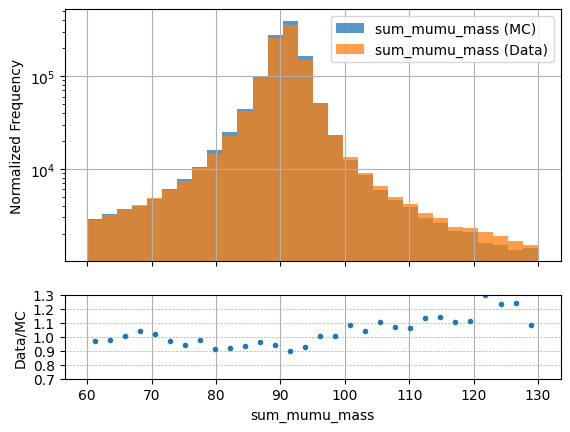

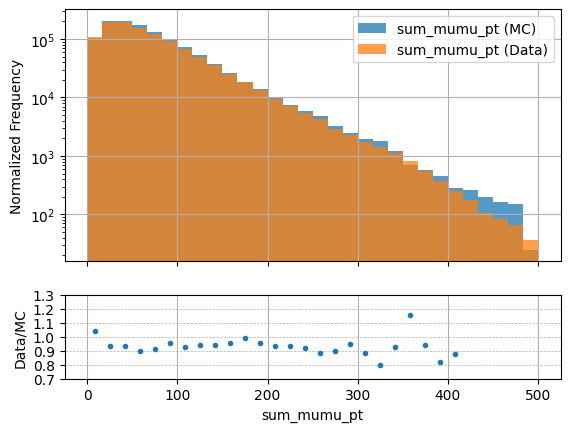

In [7]:
compare_histograms(tree_dy, tree_data, 'sum_mumu_mass', bins=30, range=(60,130))
compare_histograms(tree_dy, tree_data, 'sum_mumu_pt', bins=30, range=(0,500))

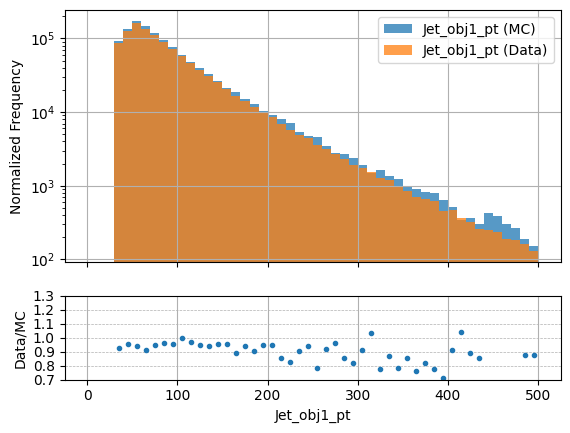

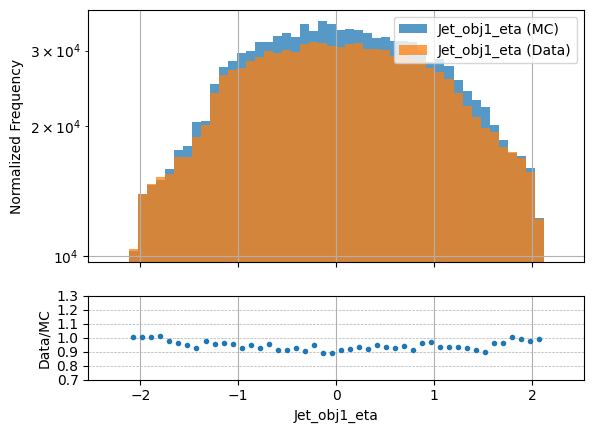

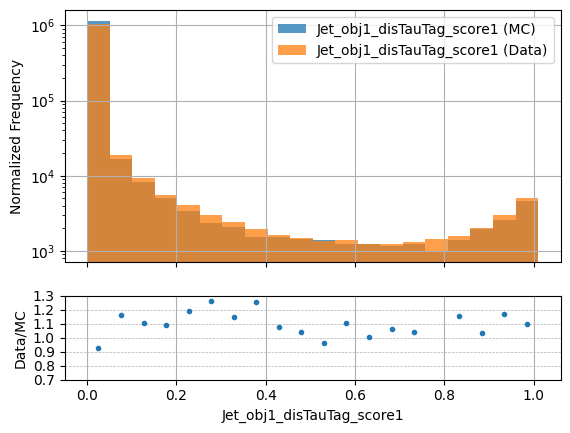

In [8]:
compare_histograms(tree_dy, tree_data, 'Jet_obj1_pt', bins=50, range=(0.0, 500))
compare_histograms(tree_dy, tree_data, 'Jet_obj1_eta', bins=50, range=(-2.3, 2.3))
compare_histograms(tree_dy, tree_data, 'Jet_obj1_disTauTag_score1', bins=20, range=(0.0, 1.01))

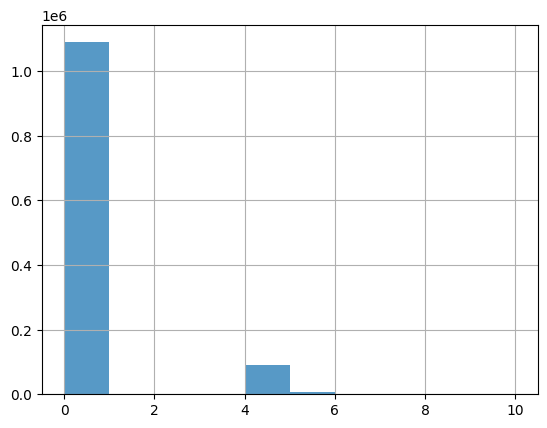

In [16]:
dy_weight = tree_dy["weight"].to_numpy()
dy_weight = (6424000 * 59.7 / 76736130.0) * dy_weight

plt.hist(tree_dy["Jet_obj1_hadronFlavour"].to_numpy(), bins=10, range=(0, 10), alpha=0.75, label=f"(MC)", weights=dy_weight)
plt.grid(True)
plt.show()

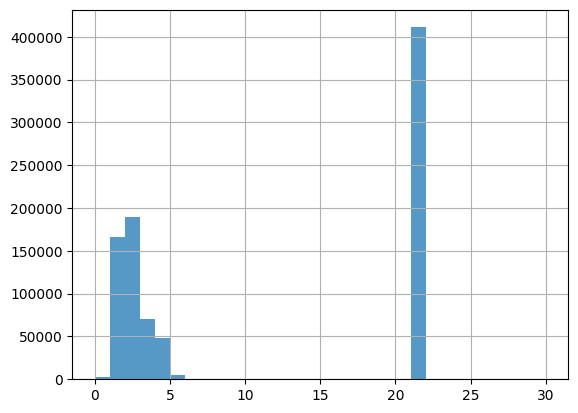

In [9]:
dy_weight = tree_dy["weight"].to_numpy() * 6424000 * 59.7 / 76736130.0

plt.hist(tree_dy["Jet_obj1_partonFlavour"].to_numpy(), bins=30, range=(0, 30), alpha=0.75, label=f"(MC)", weights=dy_weight)
plt.grid(True)
plt.show()

In [11]:
tree_dy_flavour = {}
tree_dy_flavour["light"] = ak.flatten(((tree_dy.Jet_obj1_partonFlavour >= 1) & (tree_dy.Jet_obj1_partonFlavour <= 3)) | (tree_dy.Jet_obj1_partonFlavour == 4), axis=1)
tree_dy_flavour["b"] = ak.flatten(tree_dy.Jet_obj1_partonFlavour == 5, axis=1)
tree_dy_flavour["c"] = ak.flatten(tree_dy.Jet_obj1_partonFlavour == 4, axis=1)
tree_dy_flavour["undef"] = ak.flatten(tree_dy.Jet_obj1_partonFlavour == 0, axis=1)

In [12]:
dy_weight, tree_dy_flavour["light"]

(array([5.93629229, 6.1287272 , 5.04693823, ..., 5.20471807, 7.28844242,
        7.16529897]),
 <Array [False, True, True, ... False, False] type='214748 * bool'>)

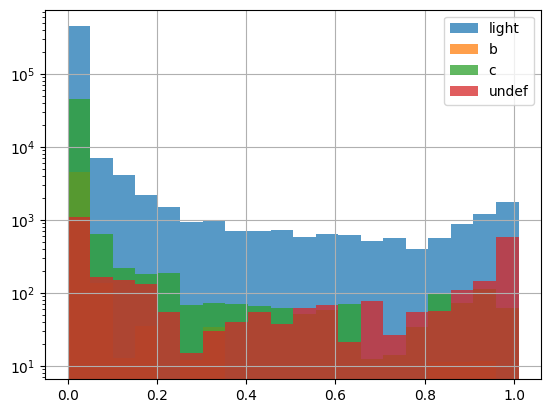

In [13]:
dy_weight = tree_dy["weight"]
dy_weight = (6424000 * 59.7 / 76736130.0) * dy_weight

light = tree_dy_flavour["light"]
b = tree_dy_flavour["b"]
c = tree_dy_flavour["c"]
undef = tree_dy_flavour["undef"]

light_score, light_weight = tree_dy.Jet_obj1_disTauTag_score1[light], dy_weight[light]
b_score, b_weight = tree_dy.Jet_obj1_disTauTag_score1[b], dy_weight[b]
c_score, c_weight = tree_dy.Jet_obj1_disTauTag_score1[c], dy_weight[c]
undef_score, undef_weight = tree_dy.Jet_obj1_disTauTag_score1[undef], dy_weight[undef]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.hist(light_score.to_numpy(), bins=20, range=(0, 1.01), alpha=0.75, weights=light_weight.to_numpy(), label="light")
ax.hist(b_score.to_numpy(), bins=20, range=(0, 1.01), alpha=0.75, weights=b_weight.to_numpy(), label="b")
ax.hist(c_score.to_numpy(), bins=20, range=(0, 1.01), alpha=0.75, weights=c_weight.to_numpy(), label="c")
ax.hist(undef_score.to_numpy(), bins=20, range=(0, 1.01), alpha=0.75, weights=undef_weight.to_numpy(), label="undef")
ax.legend()
ax.set_yscale('log')
ax.grid(True)
plt.show()

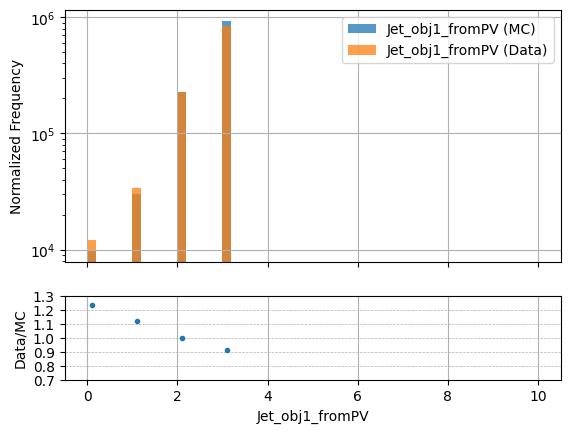

In [14]:
# "pt", "eta", "phi", "mass", "dxy", "dz", "maxdz", "dxysig", "maxdxy", 
# "maxdxysig", "dxy_weight", "dxysig_weight", "disTauTag_score1", "dz_err", 
# "dxy_err", "vz", "vxy", "fromPV", "lostInnerHits", "nConstituents", 
# "deta", "dphi"
                
compare_histograms(tree_dy, tree_data, 'Jet_obj1_fromPV', bins=50, range=(0.0, 10))

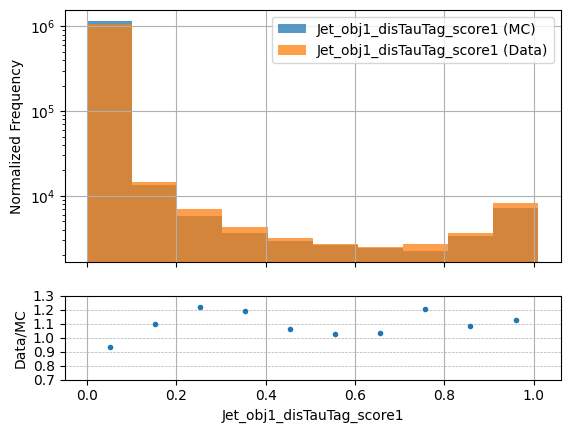

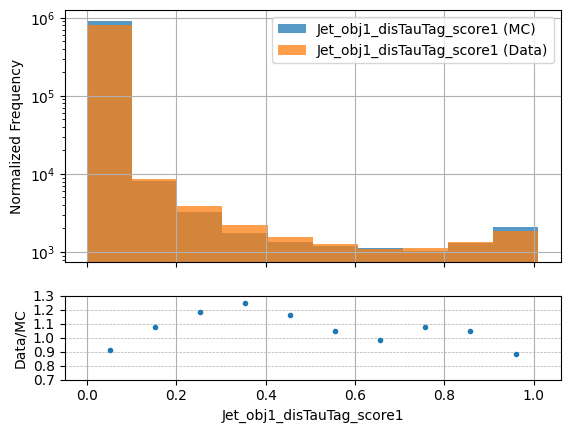

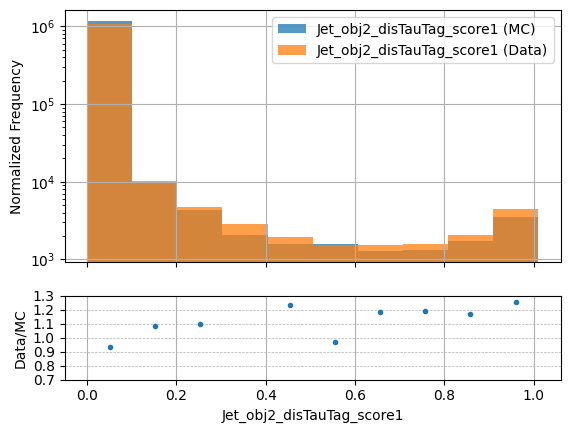

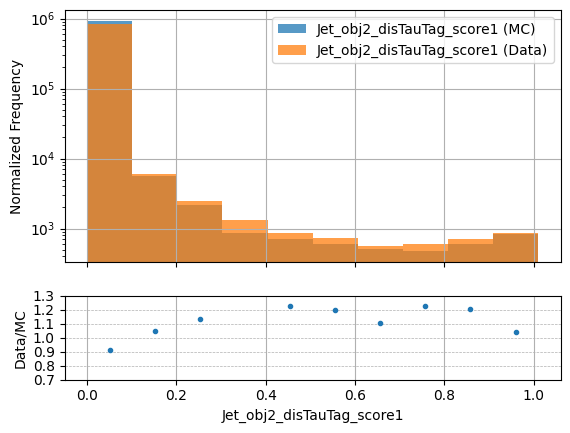

In [15]:
compare_histograms(tree_dy, tree_data, 'Jet_obj1_disTauTag_score1', bins=10, range=(0.0, 1.01), cut="")
compare_histograms(tree_dy, tree_data, 'Jet_obj1_disTauTag_score1', bins=10, range=(0.0, 1.01), cut="Jet_obj1_fromPV >= 3")
compare_histograms(tree_dy, tree_data, 'Jet_obj2_disTauTag_score1', bins=10, range=(0.0, 1.01), cut="")
compare_histograms(tree_dy, tree_data, 'Jet_obj2_disTauTag_score1', bins=10, range=(0.0, 1.01), cut="Jet_obj2_fromPV >= 3")

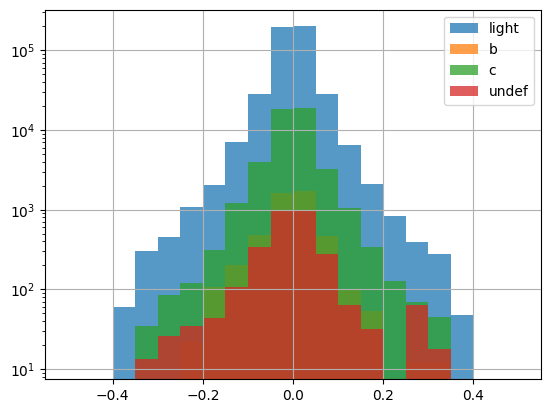

In [16]:
var_name = "Jet_obj1_deta"
x_min, x_max = -0.5, 0.5
bins = 20

dy_weight = tree_dy["weight"]
dy_weight = (6424000 * 59.7 / 76736130.0) * dy_weight

light = tree_dy_flavour["light"]
b = tree_dy_flavour["b"]
c = tree_dy_flavour["c"]
undef = tree_dy_flavour["undef"]

light_score, light_weight = tree_dy[var_name][light], dy_weight[light]
b_score, b_weight = tree_dy[var_name][b], dy_weight[b]
c_score, c_weight = tree_dy[var_name][c], dy_weight[c]
undef_score, undef_weight = tree_dy[var_name][undef], dy_weight[undef]

fig = plt.figure()
ax = fig.add_subplot(1, 1, 1)

ax.hist(light_score.to_numpy(), bins=bins, range=(x_min, x_max), alpha=0.75, weights=light_weight.to_numpy(), label="light")
ax.hist(b_score.to_numpy(), bins=bins, range=(x_min, x_max), alpha=0.75, weights=b_weight.to_numpy(), label="b")
ax.hist(c_score.to_numpy(), bins=bins, range=(x_min, x_max), alpha=0.75, weights=c_weight.to_numpy(), label="c")
ax.hist(undef_score.to_numpy(), bins=bins, range=(x_min, x_max), alpha=0.75, weights=undef_weight.to_numpy(), label="undef")
ax.legend()
ax.set_yscale('log')
ax.grid(True)
plt.show()

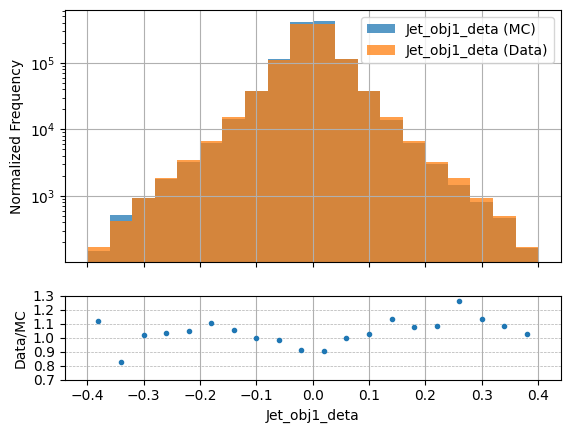

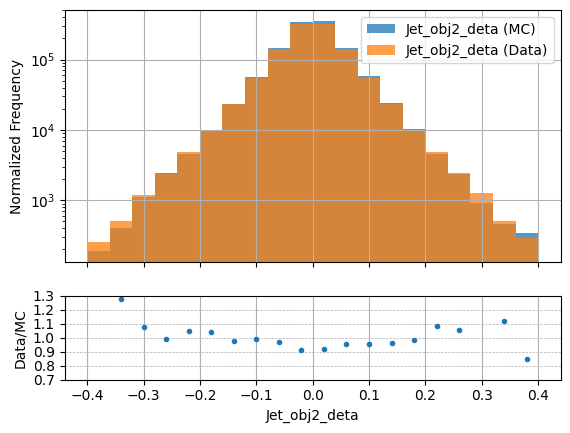

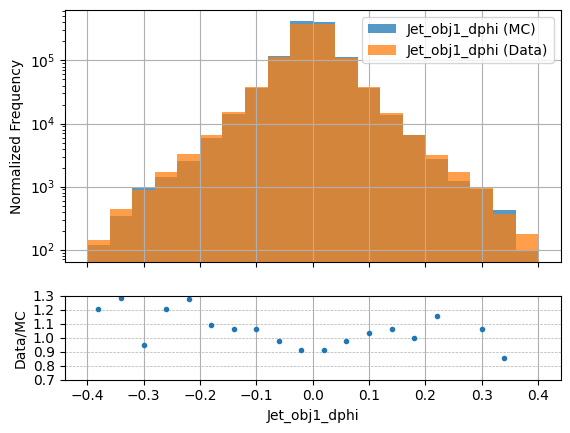

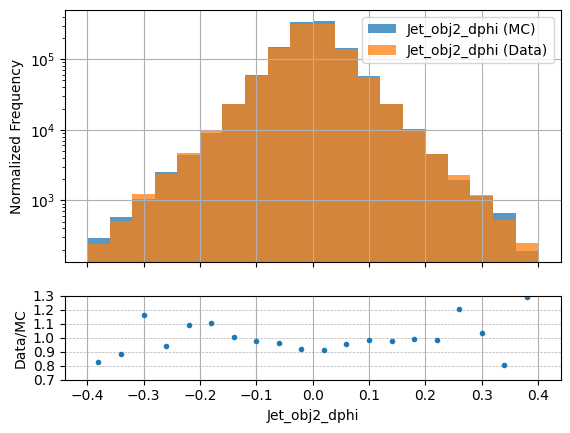

In [17]:
compare_histograms(tree_dy, tree_data, 'Jet_obj1_deta', bins=20, range=(-0.4, 0.4), cut="")
compare_histograms(tree_dy, tree_data, 'Jet_obj2_deta', bins=20, range=(-0.4, 0.4), cut="")
compare_histograms(tree_dy, tree_data, 'Jet_obj1_dphi', bins=20, range=(-0.4, 0.4), cut="")
compare_histograms(tree_dy, tree_data, 'Jet_obj2_dphi', bins=20, range=(-0.4, 0.4), cut="")

In [7]:
from scipy.interpolate import RegularGridInterpolator

In [22]:
def calculate_2d_weights(data_pt, data_eta, mc_pt, mc_eta, mc_initial_weights, pt_bins, eta_bins):
    """
    Calculate reweighting factors based on 2D histograms of pt and eta,
    including initial event weights for MC.
    """
    # Create 2D histograms for data
    data_hist, _, _ = np.histogram2d(data_pt, data_eta, bins=[pt_bins, eta_bins], density=True)
    
    # Create 2D histograms for MC, including initial weights
    mc_hist, pt_edges, eta_edges = np.histogram2d(mc_pt, mc_eta, bins=[pt_bins, eta_bins], weights=mc_initial_weights, density=True)
    print(mc_hist)
    # Avoid division by zero by setting any zero entries to a small number
#     mc_hist[mc_hist == 0] = 1e-12
    _weights = np.where( mc_hist != 0, data_hist / mc_hist, 1.0)
#     weights[mc_hist == 0] = 1.0
    
#     print(weights)
    

    # Interpolator for weights, based on the center of bins
    pt_centers = (pt_edges[:-1] + pt_edges[1:]) / 2
    eta_centers = (eta_edges[:-1] + eta_edges[1:]) / 2
    interpolator = RegularGridInterpolator((pt_centers, eta_centers), _weights, bounds_error=False, fill_value=1)

    # Calculate MC weights based on the interpolator
    mc_points = np.vstack((mc_pt, mc_eta)).T
    _weights = interpolator(mc_points)

    return _weights


In [ ]:
# Define bins
input_bins = [
    np.linspace(30, 500, 50),  # Example pt bins
    np.linspace(-2.3, 2.3, 20)  # Example eta bins
]

input_vars = [
    ak.flatten(tree_data["Jet_obj1_pt"]).to_numpy(),
    ak.flatten(tree_data["Jet_obj1_eta"]).to_numpy(),
    ak.flatten(tree_dy["Jet_obj1_pt"]).to_numpy(),
    ak.flatten(tree_dy["Jet_obj1_eta"]).to_numpy()
]

weights = calculate_2d_weights(*input_vars, dy_weight, *input_bins)

In [20]:
print(len(weights))
print(len(tree_dy.weight.to_numpy()))

214748
214748


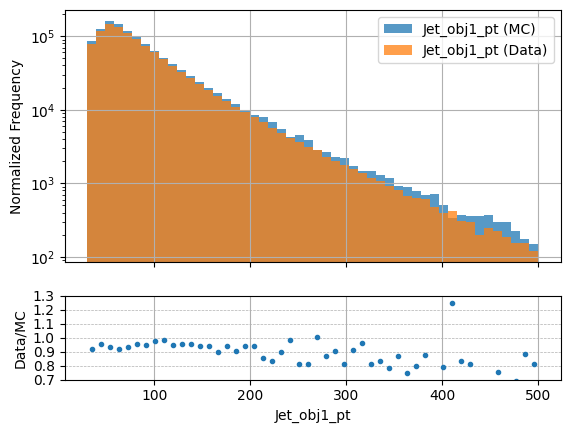

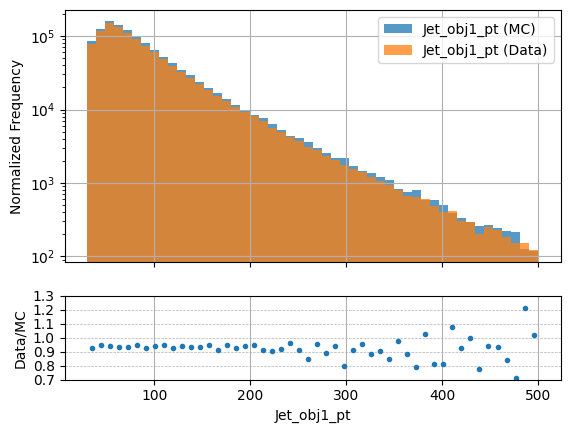

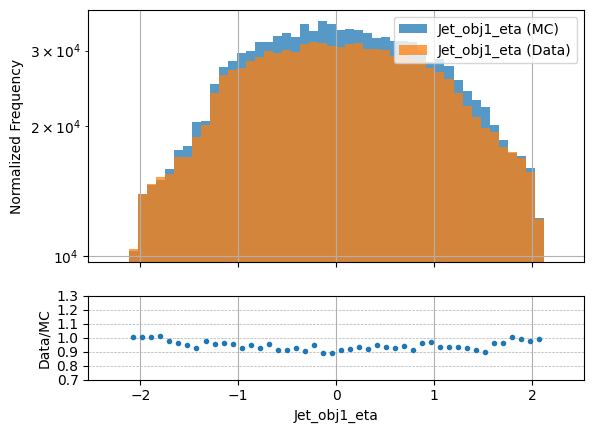

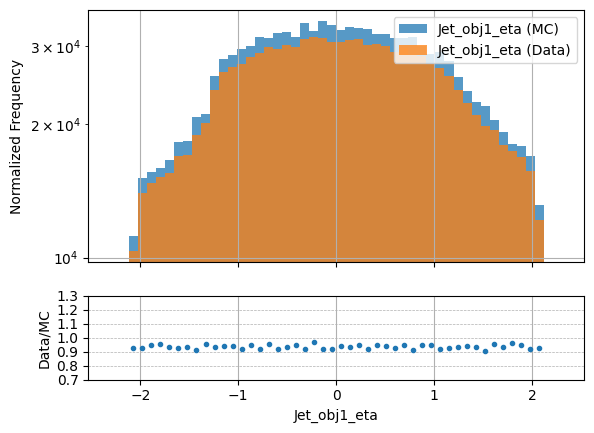

In [21]:
compare_histograms(tree_dy, tree_data, 'Jet_obj1_pt', bins=50, range=(30.0, 500))
compare_histograms(tree_dy, tree_data, 'Jet_obj1_pt', ext_weight = weights, bins=50, range=(30.0, 500))
compare_histograms(tree_dy, tree_data, 'Jet_obj1_eta', bins=50, range=(-2.3, 2.3))
compare_histograms(tree_dy, tree_data, 'Jet_obj1_eta', ext_weight = weights, bins=50, range=(-2.3, 2.3))

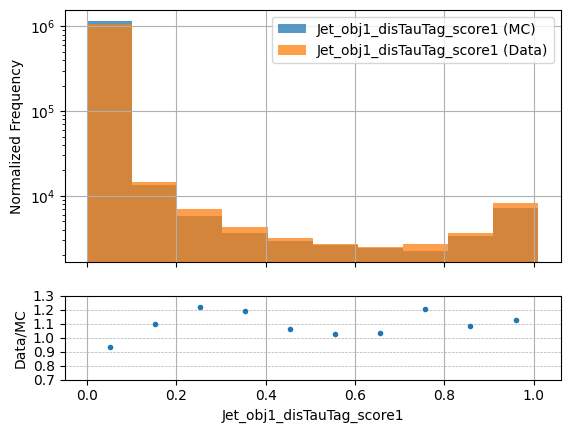

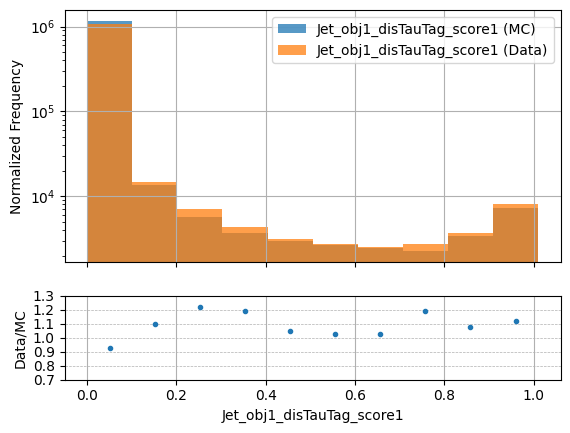

In [22]:
compare_histograms(tree_dy, tree_data, 'Jet_obj1_disTauTag_score1', bins=10, range=(0.0, 1.01), cut="")
compare_histograms(tree_dy, tree_data, 'Jet_obj1_disTauTag_score1', ext_weight = weights, bins=10, range=(0.0, 1.01), cut="")

In [36]:
# Define bins
input_bins = [
    np.linspace(-0.4, 0.4, 50),  # Example phi bins
    np.linspace(-0.4, 0.4, 50)  # Example eta bins
]

input_vars = [
    ak.flatten(tree_data["Jet_obj1_deta"]).to_numpy(),
    ak.flatten(tree_data["Jet_obj1_dphi"]).to_numpy(),
    ak.flatten(tree_dy["Jet_obj1_deta"]).to_numpy(),
    ak.flatten(tree_dy["Jet_obj1_dphi"]).to_numpy()
]

weights_detadphi = calculate_2d_weights(*input_vars, dy_weight, *input_bins)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]
[[1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 ...
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]
 [1. 1. 1. ... 1. 1. 1.]]


/tmp/ipykernel_64918/570858110.py:15: RuntimeWarning: divide by zero encountered in divide
  _weights = np.where( mc_hist != 0, data_hist / mc_hist, 1.0)
/tmp/ipykernel_64918/570858110.py:15: RuntimeWarning: invalid value encountered in divide
  _weights = np.where( mc_hist != 0, data_hist / mc_hist, 1.0)


ValueError: One of the requested xi is out of bounds in dimension 0

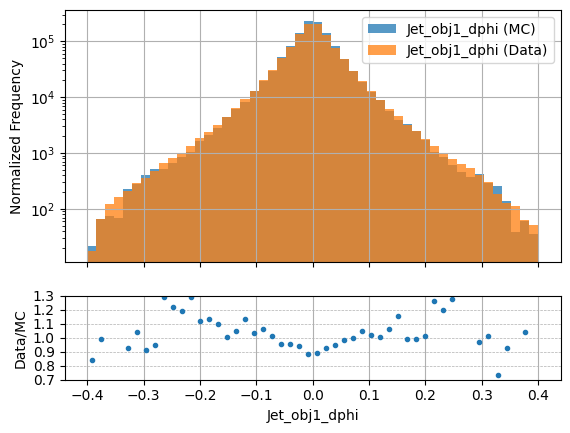

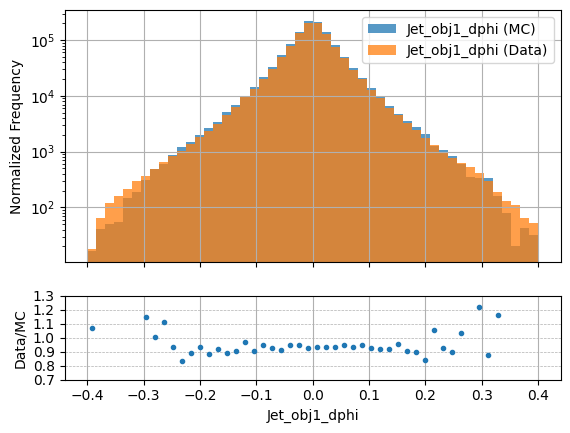

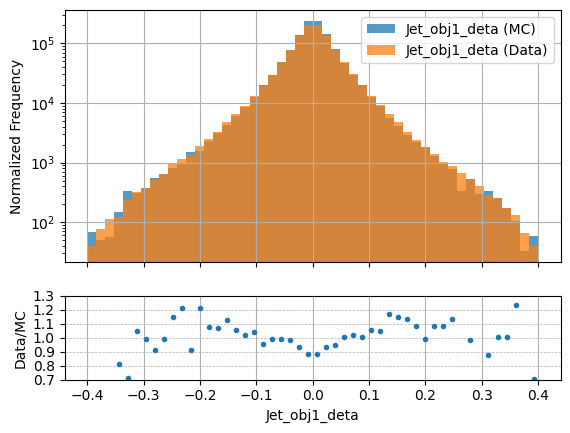

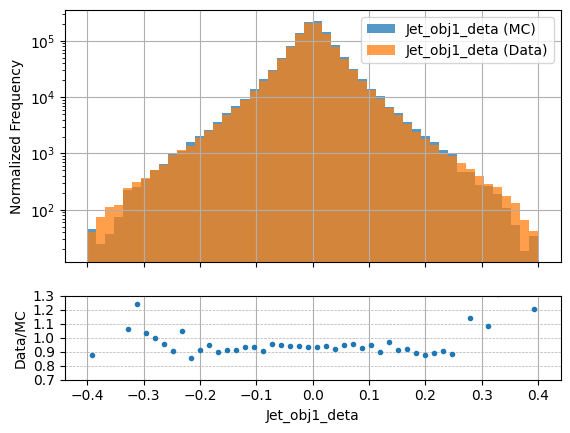

In [24]:
compare_histograms(tree_dy, tree_data, 'Jet_obj1_dphi', bins=50, range=(-0.4, 0.4))
compare_histograms(tree_dy, tree_data, 'Jet_obj1_dphi', ext_weight = weights_detadphi, bins=50, range=(-0.4, 0.4))
compare_histograms(tree_dy, tree_data, 'Jet_obj1_deta', bins=50, range=(-0.4, 0.4))
compare_histograms(tree_dy, tree_data, 'Jet_obj1_deta', ext_weight = weights_detadphi, bins=50, range=(-0.4, 0.4))

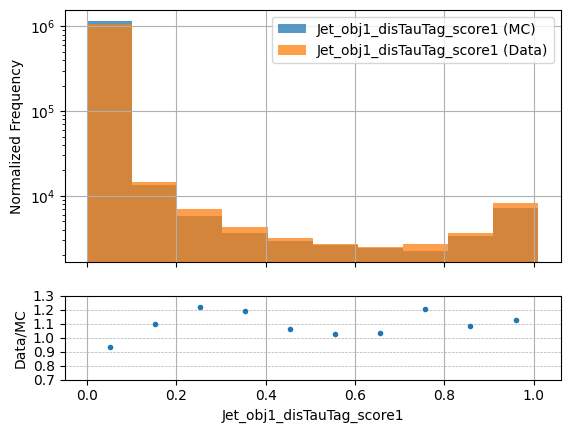

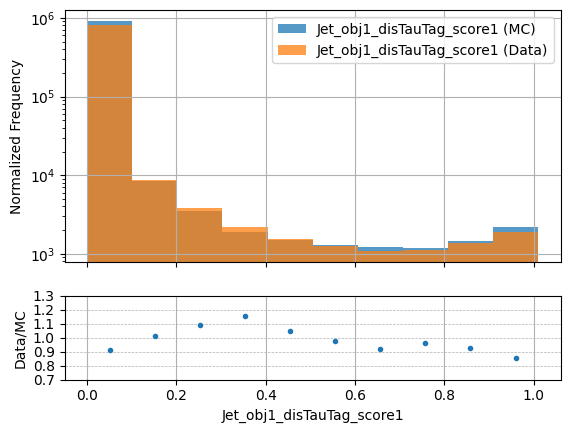

In [25]:
compare_histograms(tree_dy, tree_data, 'Jet_obj1_disTauTag_score1', bins=10, range=(0.0, 1.01), cut="")
compare_histograms(tree_dy, tree_data, 'Jet_obj1_disTauTag_score1', ext_weight = weights_detadphi, bins=10, range=(0.0, 1.01), cut="Jet_obj1_fromPV >= 3")

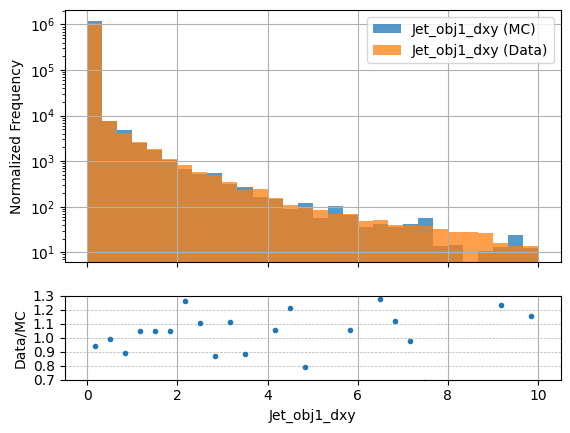

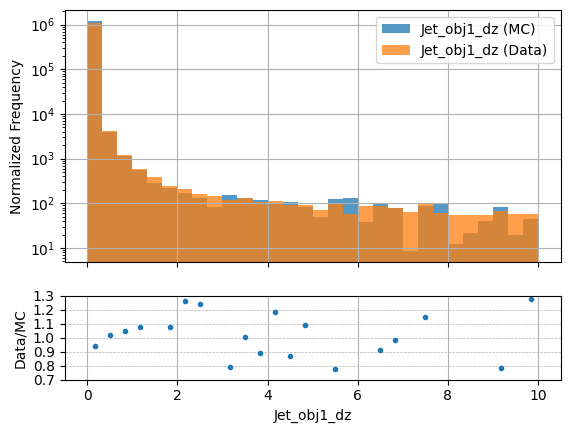

In [26]:
compare_histograms(tree_dy, tree_data, 'Jet_obj1_dxy', bins=30, range=(0.0, 10.0), cut="")
compare_histograms(tree_dy, tree_data, 'Jet_obj1_dz', bins=30, range=(0.0, 10.0), cut="")

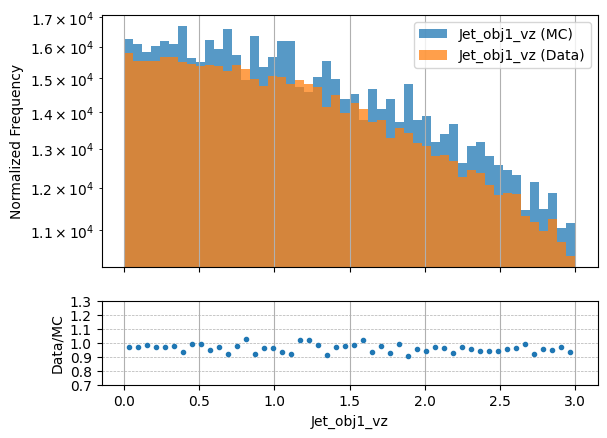

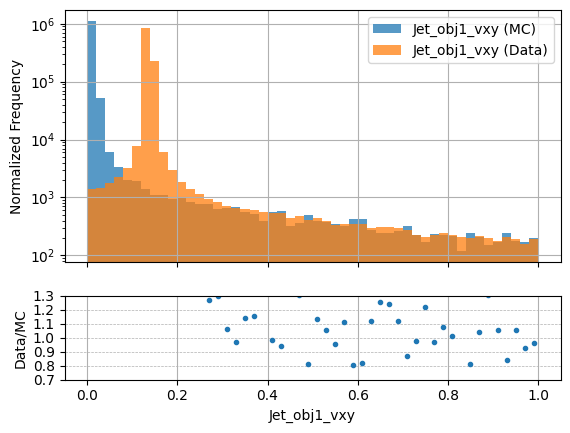

In [12]:
compare_histograms(tree_dy, tree_data, 'Jet_obj1_vz', bins=50, range=(0.0, 3.0), cut="")
compare_histograms(tree_dy, tree_data, 'Jet_obj1_vxy', bins=50, range=(0.0, 1.0), cut="")
# compare_histograms(tree_dy, tree_data, 'Jet_obj1_disTauTag_score1', bins=10, range=(0.0, 1.01), cut="")

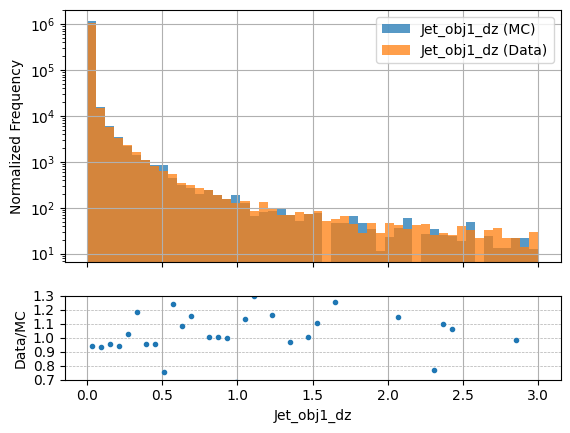

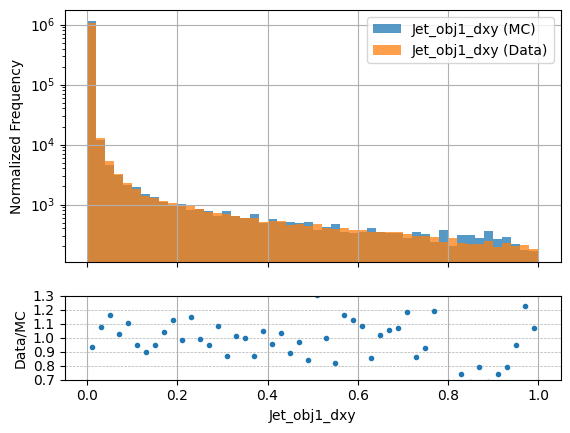

In [13]:
compare_histograms(tree_dy, tree_data, 'Jet_obj1_dz', bins=50, range=(0.0, 3.0), cut="")
compare_histograms(tree_dy, tree_data, 'Jet_obj1_dxy', bins=50, range=(0.0, 1.0), cut="")

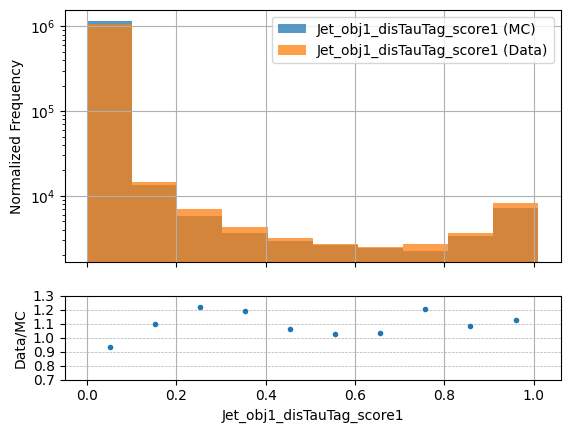

In [ ]:
compare_histograms(tree_dy, tree_data, 'Jet_obj1_disTauTag_score1', bins=10, range=(0.0, 1.01), cut="")
compare_histograms(tree_dy, tree_data, 'Jet_obj1_disTauTag_score1', bins=10, range=(0.0, 1.01), cut="(Jet_obj1_fromPV >= 3)&(Jet_obj1_vxy < 1.0)&(sum_mumu_mass>80)&(sum_mumu_mass<100)")

In [20]:
# Define bins
input_bins = [
    np.linspace(0, 2, 20),  # Example pt bins
    np.linspace(0, 2, 20)  # Example eta bins
]

input_vars = [
    ak.flatten(tree_data["Jet_obj1_vxy"]).to_numpy(),
    ak.flatten(tree_data["Jet_obj1_vz"]).to_numpy(),
    ak.flatten(tree_dy["Jet_obj1_vxy"]).to_numpy(),
    ak.flatten(tree_dy["Jet_obj1_vz"]).to_numpy()
]

weights = calculate_2d_weights(*input_vars, dy_weight, *input_bins)

/tmp/ipykernel_87704/2989419354.py:14: RuntimeWarning: divide by zero encountered in divide
  _weights = np.where( mc_hist != 0, data_hist / mc_hist, 1.0)
/tmp/ipykernel_87704/2989419354.py:14: RuntimeWarning: invalid value encountered in divide
  _weights = np.where( mc_hist != 0, data_hist / mc_hist, 1.0)


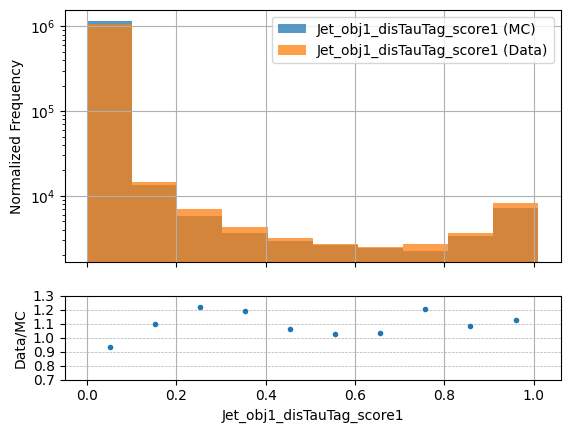

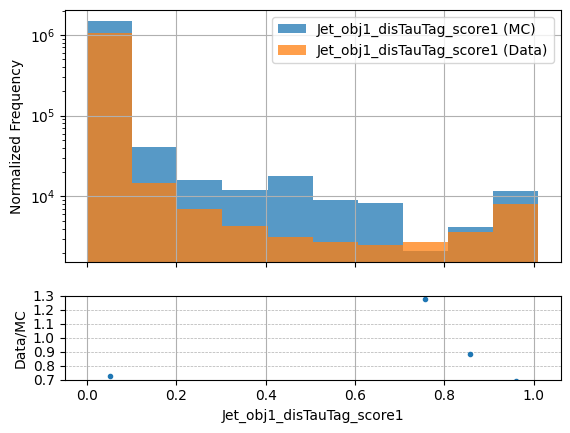

In [22]:
compare_histograms(tree_dy, tree_data, 'Jet_obj1_disTauTag_score1', bins=10, range=(0.0, 1.01), cut="")
compare_histograms(tree_dy, tree_data, 'Jet_obj1_disTauTag_score1', ext_weight = weights, bins=10, range=(0.0, 1.01))

In [10]:
## Do 1D reweighing and then check what is changed

In [54]:
import numpy as np
from scipy.interpolate import RegularGridInterpolator

def calculate_2d_weights(data_pt, data_eta, mc_pt, mc_eta, mc_initial_weights, pt_bins, eta_bins):
    """
    Calculate reweighting factors based on 2D histograms of pt and eta,
    including initial event weights for MC. Handles overflow and underflow bins.
    """
    # Clip data and MC to include underflow and overflow in the histograms
    data_pt = np.clip(data_pt, pt_bins[0], pt_bins[-1])
    data_eta = np.clip(data_eta, eta_bins[0], eta_bins[-1])
    mc_pt = np.clip(mc_pt, pt_bins[0], pt_bins[-1])
    mc_eta = np.clip(mc_eta, eta_bins[0], eta_bins[-1])

    # Create 2D histograms for data and MC
    data_hist, _, _ = np.histogram2d(data_pt, data_eta, bins=[pt_bins, eta_bins], density=True)
    mc_hist, pt_edges, eta_edges = np.histogram2d(mc_pt, mc_eta, bins=[pt_bins, eta_bins], weights=mc_initial_weights, density=True)
    
    print(pt_edges)
    print(eta_edges)
    
    # Avoid division by zero by setting zero entries to a small number
    mc_hist[mc_hist == 0] = 1e-12
    weights = data_hist / mc_hist
    print(weights)

    # Create an interpolator for weights
    pt_centers = (pt_edges[:-1] + pt_edges[1:]) / 2
    eta_centers = (eta_edges[:-1] + eta_edges[1:]) / 2
    interpolator = RegularGridInterpolator((pt_centers, eta_centers), weights, bounds_error=True)

    # Calculate MC weights based on the interpolator
    mc_points = np.vstack((mc_pt, mc_eta)).T
    mc_weights = interpolator(mc_points)

    return mc_weights

# Example usage could proceed here...



In [61]:
import numpy as np
from scipy.interpolate import interp1d

def calculate_1d_weights(data, mc, data_weight, mc_initial_weights, bins):
    """
    Calculate reweighting factors based on 1D histograms.
    
    Parameters:
    - data: Array of data for the variable to be reweighted.
    - mc: Array of MC data for the variable.
    - mc_initial_weights: Array of initial weights for the MC data.
    - bins: Array defining the bin edges for histogramming.
    
    Returns:
    - A function that can be used to get weights for any MC value.
    """
    # Clip data and MC to include underflow and overflow
    data = np.clip(data, bins[0], bins[-1])
    mc = np.clip(mc, bins[0], bins[-1])

    # Create histograms
#     data_hist, _ = np.histogram(data, bins=bins, weights=data_weight, density=True)
#     mc_hist, bin_edges = np.histogram(mc, bins=bins, weights=mc_initial_weights, density=True)
    data_hist, _ = np.histogram(data, bins=bins, weights=data_weight)
    mc_hist, bin_edges = np.histogram(mc, bins=bins, weights=mc_initial_weights)
#     print(bin_edges)

    # Avoid division by zero by setting zero entries to a small number
    mc_hist[mc_hist == 0] = 1e-12
    weights = data_hist / mc_hist
    # add duplication weight for the last bin_edge (to be analogical with root hist)
    weights = np.append(weights, weights[-1])
#     print(weights)
    
    # Interpolate to find weights for all MC events
#     bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
#     weight_func = interp1d(bin_centers, weights, bounds_error=False, fill_value=np.nan)
    weight_func = interp1d(bin_edges, weights, kind="previous")
    
    mc_weights = weight_func(mc)
    

    return mc_weights

In [62]:
input_bins = [
    np.linspace(0.0, 1.00, 101),  # n bins + 1
]

input_vars = [
    ak.flatten(tree_data["Jet_obj1_disTauTag_score1"]).to_numpy(),
    ak.flatten(tree_dy["Jet_obj1_disTauTag_score1"]).to_numpy(),
]

dy_weight = 6424000 * 59.7 / 76736130.0 * tree_dy["weight"].to_numpy().flatten()
data_weight = tree_data["weight"].to_numpy().flatten()

weights_score = calculate_1d_weights(*input_vars, data_weight, dy_weight, *input_bins)

In [83]:
import numpy as np
import matplotlib.pyplot as plt
import numexpr as ne
import re
import awkward as ak

def compare_histograms(lazy_tree1, lazy_tree2, var_name, ext_weight=None, bins=100, range=(60, 140), log_scale=True, cut=None):
    """
    Plots and compares histograms from two lazy trees and adds a ratio plot with uncertainty.
    """
    data1 = lazy_tree1[var_name].to_numpy().flatten()
    data2 = lazy_tree2[var_name].to_numpy().flatten()
        
    if cut is not None:
        # Convert lazy array to NumPy array for the main variable and apply cuts
        env1 = {var_name: lazy_tree1[var_name].to_numpy() for var_name in re.findall(r'[a-zA-Z_]\w*', cut)}
        env2 = {var_name: lazy_tree2[var_name].to_numpy() for var_name in re.findall(r'[a-zA-Z_]\w*', cut)}

        mask1 = ne.evaluate(cut, local_dict=env1) if cut else np.ones_like(env1[var_name], dtype=bool)
        mask2 = ne.evaluate(cut, local_dict=env2) if cut else np.ones_like(env2[var_name], dtype=bool)
        
        mask1 = np.flatten(mask1)
        mask2 = np.flatten(mask2)
        
        data1 = data1[mask1]
        data2 = data2[mask2]
    
    # Calculate weights
    dy_weight = 6424000 * 59.7 / 76736130.0 * lazy_tree1["weight"].to_numpy().flatten()
    data_weight = lazy_tree2["weight"].to_numpy().flatten()
    
    if ext_weight is not None:
        dy_weight *= ext_weight
    
    if cut is not None:
        dy_weight = dy_weight[mask1]
        data_weight = data_weight[mask2]
    
#     print(data1.shape)
#     print(dy_weight.shape)
    # Create histograms
    counts1, bin_edges = np.histogram(data1, bins=bins, range=range, weights=dy_weight)
    counts2, _ = np.histogram(data2, bins=bins, range=range, weights=data_weight)
#     print(bin_edges)

    # Calculate errors for Poisson statistics
    errors1 = np.sqrt(counts1)
    errors2 = np.sqrt(counts2)
    ratio = counts2 / counts1
    ratio_errors = ratio * np.sqrt((errors2 / counts2)**2 + (errors1 / counts1)**2)

    # Create a plot with two subplots
    fig, (ax1, ax2) = plt.subplots(2, 1, gridspec_kw={'height_ratios': [3, 1]}, sharex=True)
    ax1.hist(data1, bins=bins, range=range, alpha=0.75, label=f"{var_name} (MC)", weights=dy_weight, density=True)
    ax1.hist(data2, bins=bins, range=range, alpha=0.75, label=f"{var_name} (Data)", weights=data_weight, density=True)
    ax1.set_ylabel("Normalized Frequency")
    ax1.legend()
    ax1.grid(True)
    if log_scale:
        ax1.set_yscale('log')
    
    # Adding a ratio plot with error bars
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    ax2.errorbar(bin_centers, ratio, yerr=ratio_errors, fmt='o', markersize=3, capsize=2)
    ax2.set_ylabel('Data/MC')
    ax2.set_xlabel(var_name)
    ax2.grid(True, which='both', axis='y', linestyle='--', linewidth=0.5)
    ax2.set_ylim(0.7, 1.3)  # Adjust y-axis limits for visibility

    plt.show()

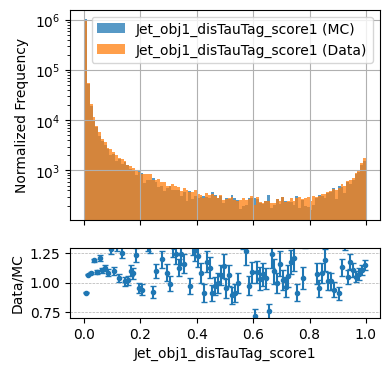

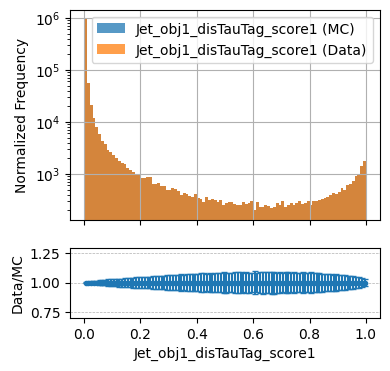

In [69]:
compare_histograms(tree_dy, tree_data, 'Jet_obj1_disTauTag_score1', bins=100, range=(0.0, 1.0))
compare_histograms(tree_dy, tree_data, 'Jet_obj1_disTauTag_score1', ext_weight = weights_score, bins=100, range=(0.0, 1.0))

/tmp/ipykernel_3185/2740772786.py:49: RuntimeWarning: invalid value encountered in divide
  ratio = counts2 / counts1
/tmp/ipykernel_3185/2740772786.py:50: RuntimeWarning: invalid value encountered in divide
  ratio_errors = ratio * np.sqrt((errors2 / counts2)**2 + (errors1 / counts1)**2)


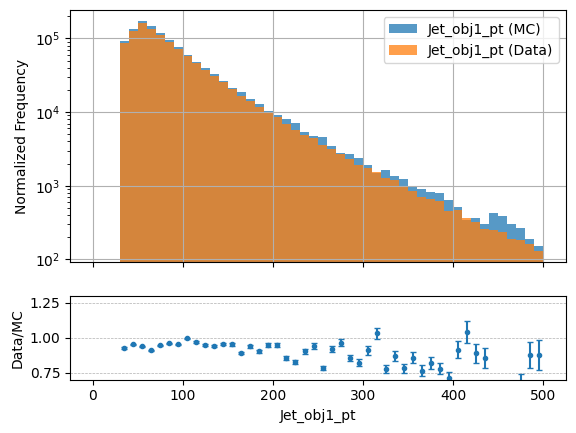

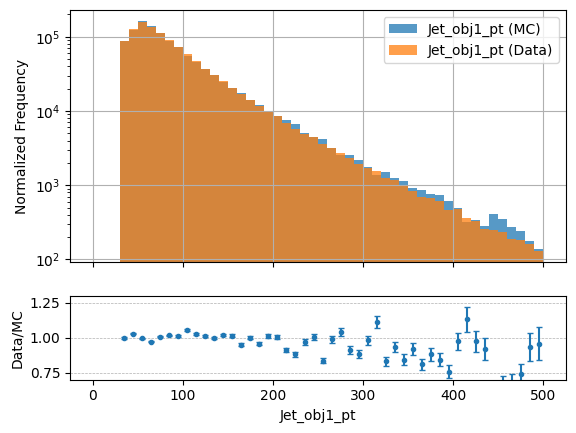

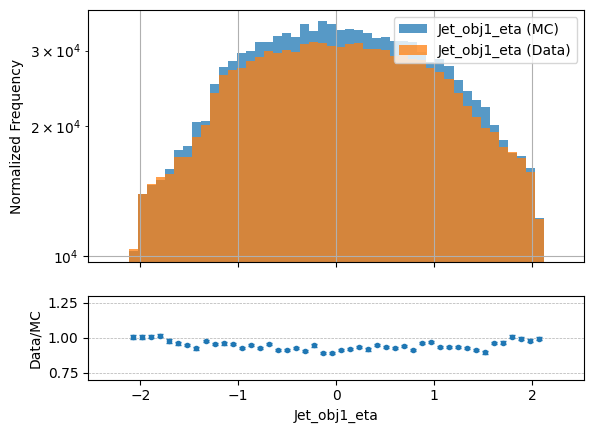

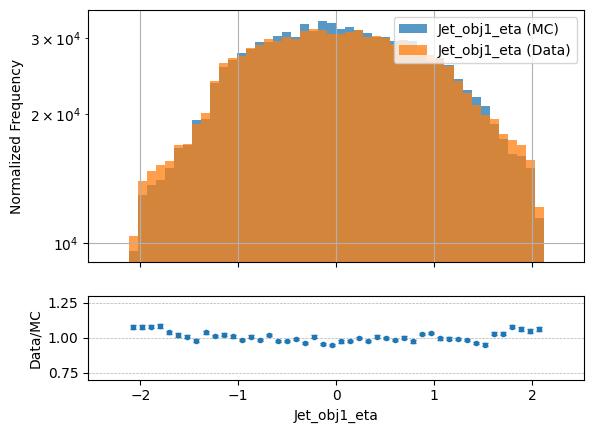

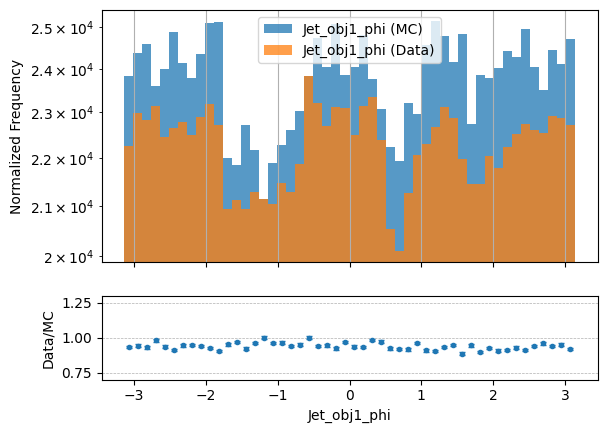

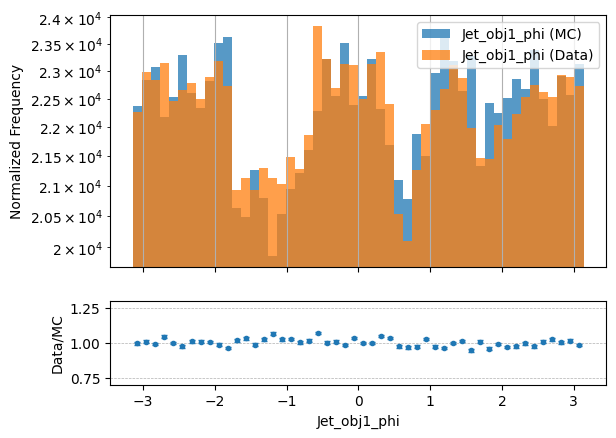

/tmp/ipykernel_3185/2740772786.py:49: RuntimeWarning: divide by zero encountered in divide
  ratio = counts2 / counts1


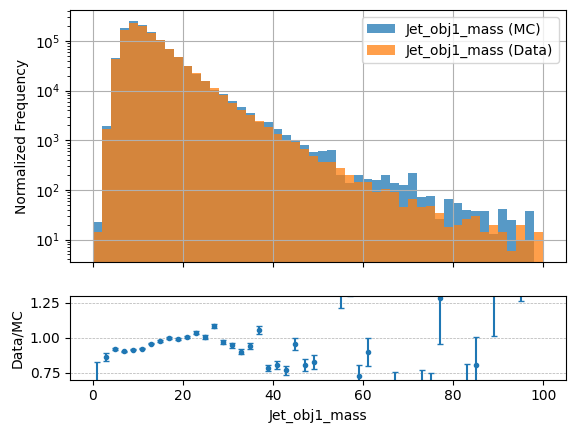

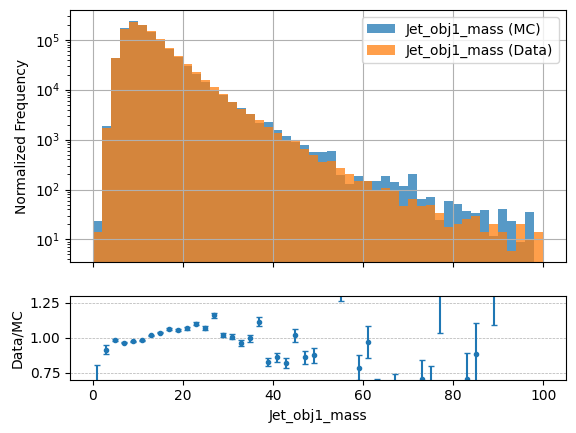

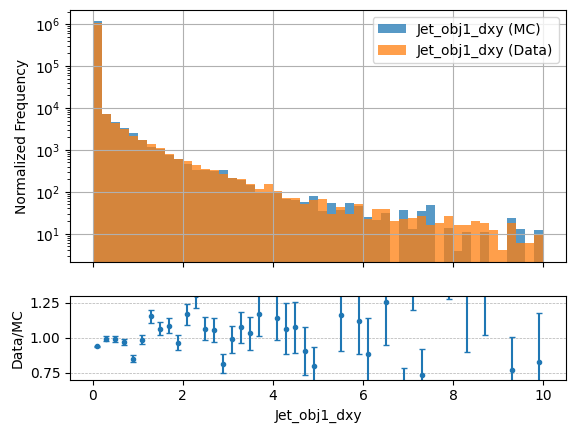

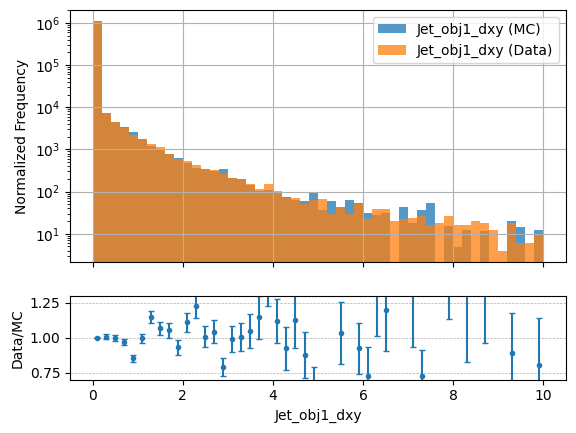

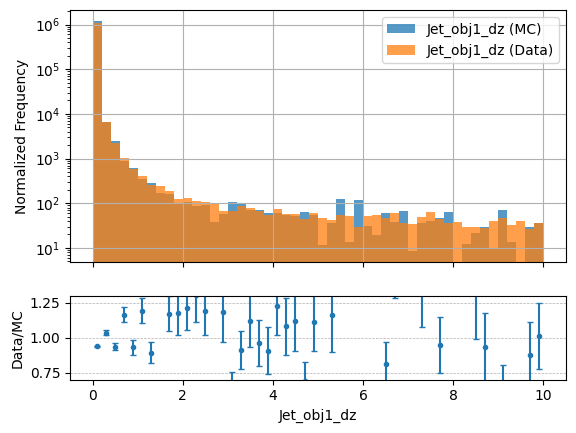

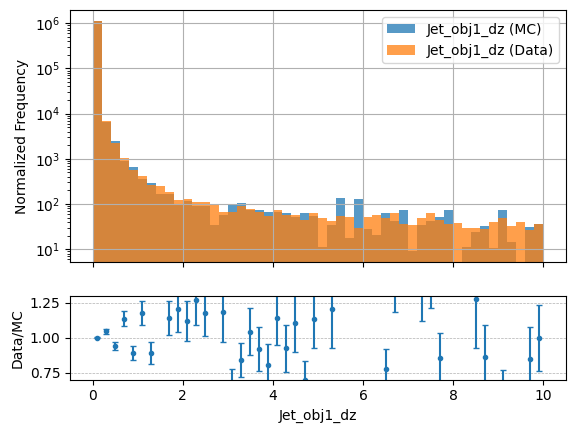

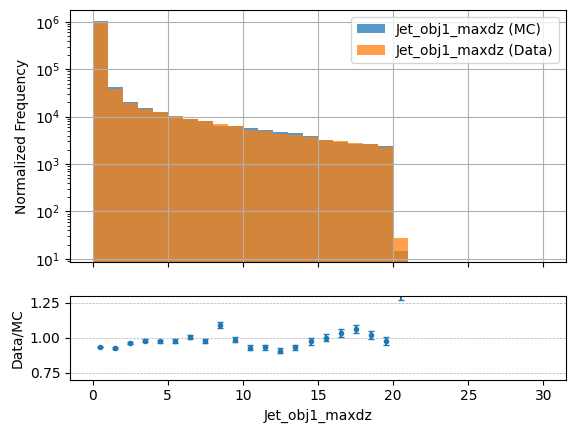

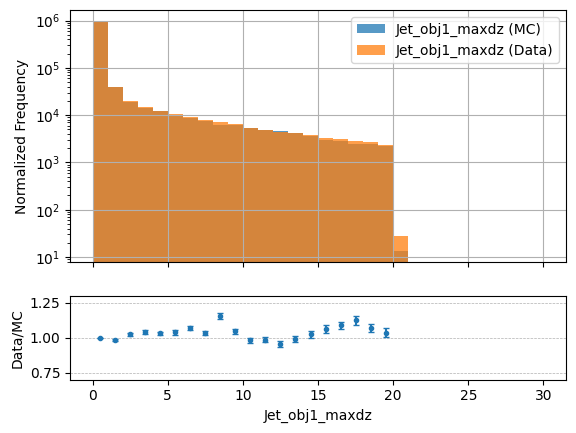

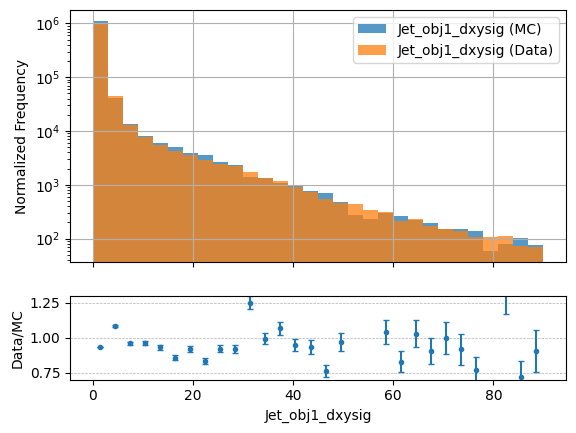

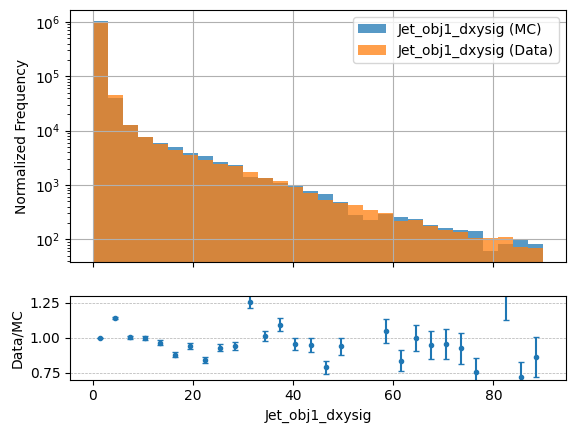

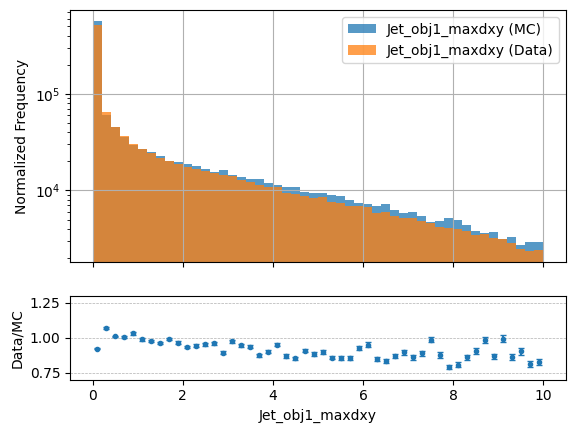

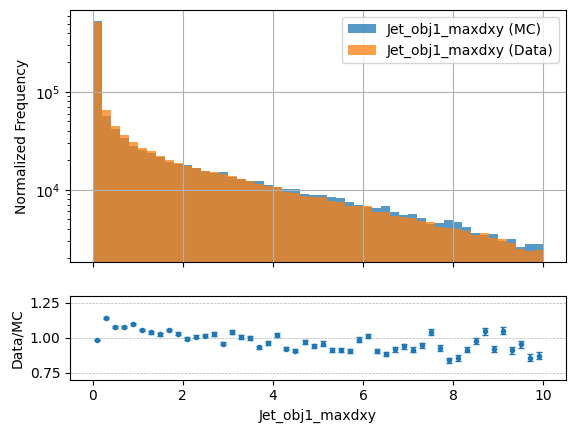

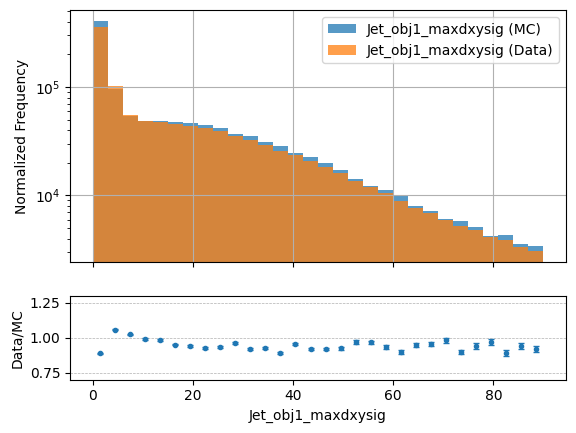

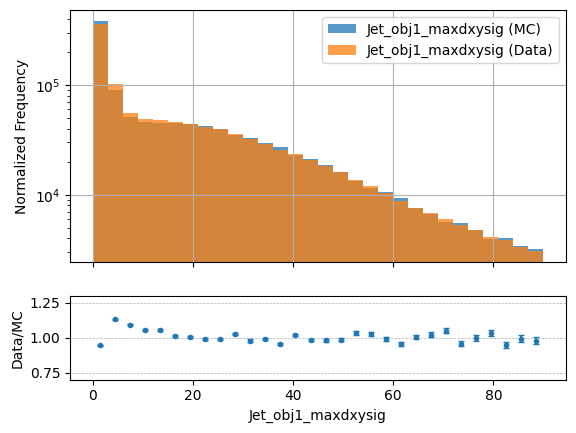

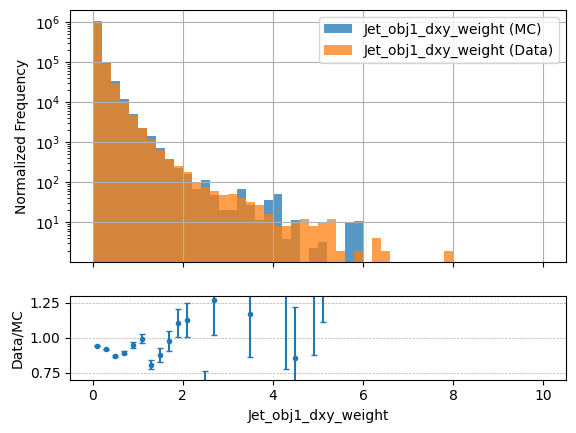

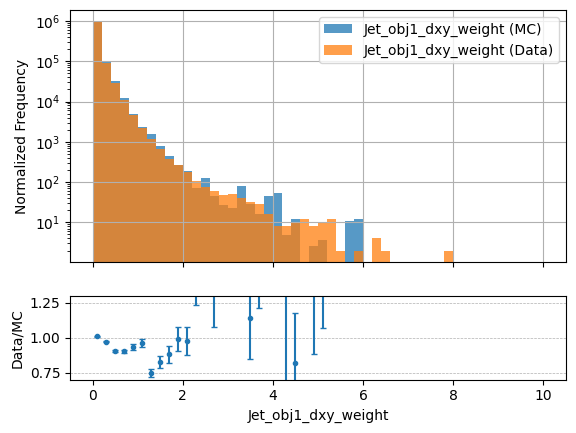

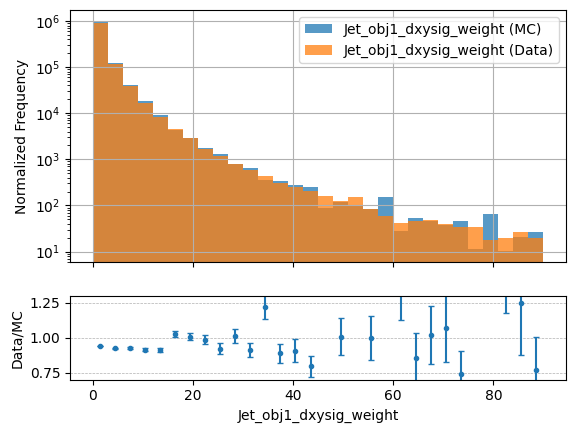

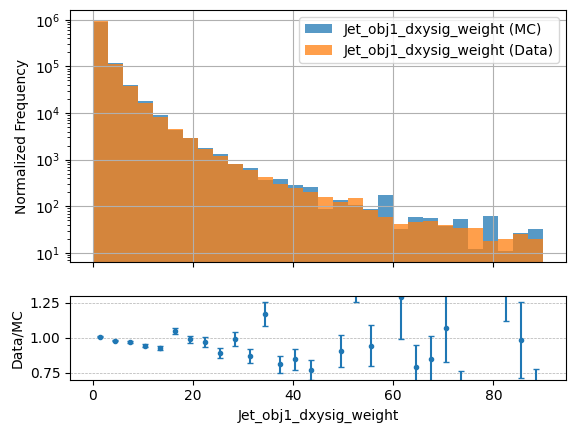

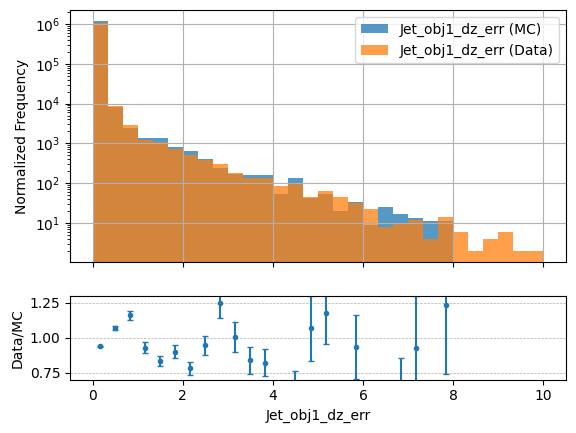

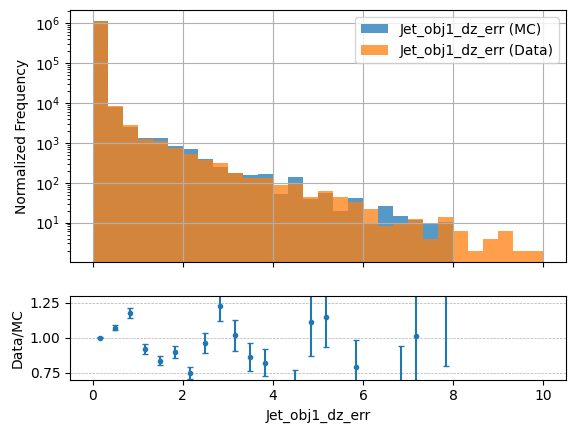

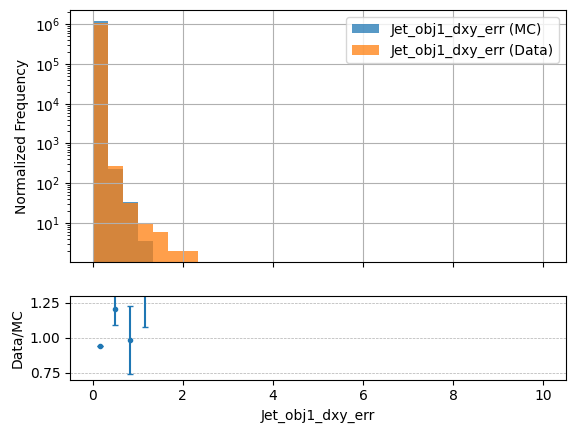

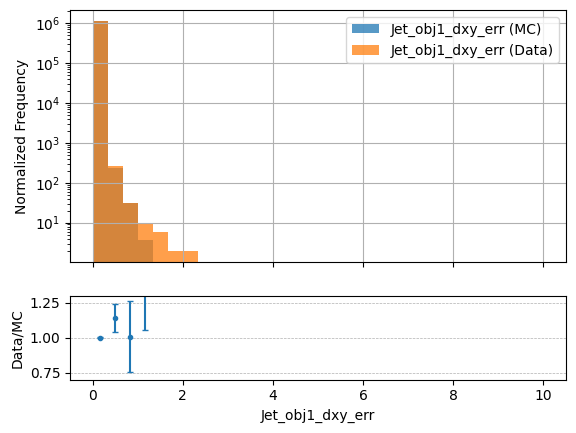

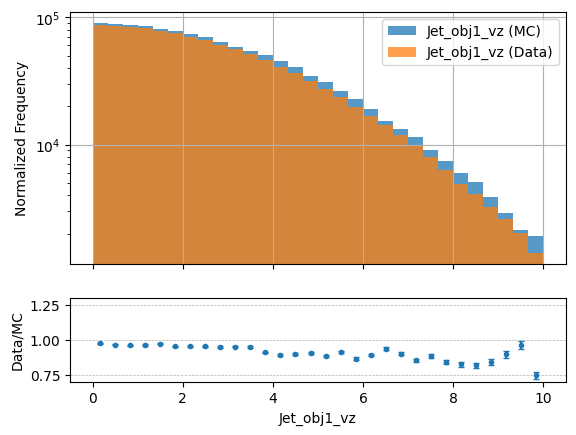

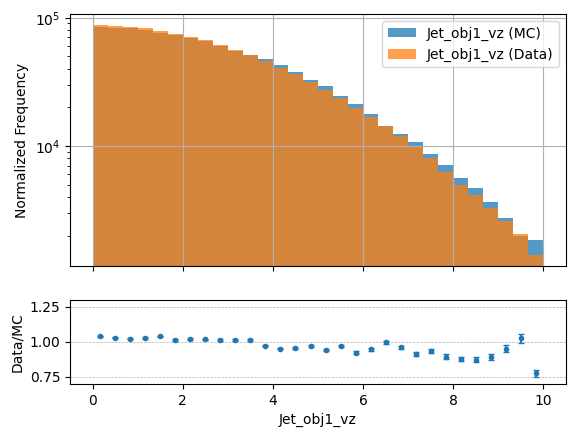

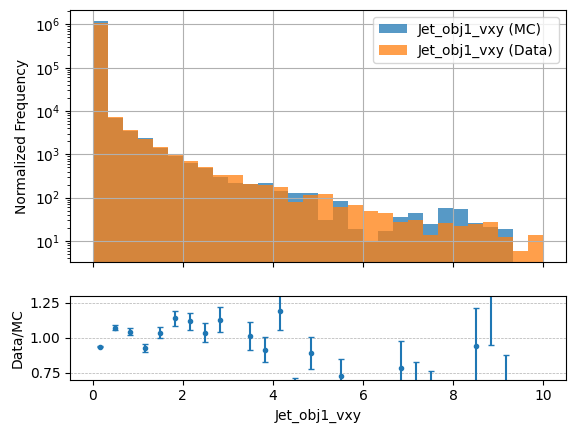

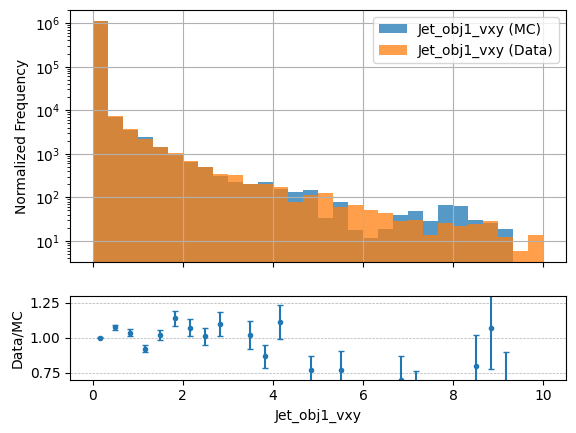

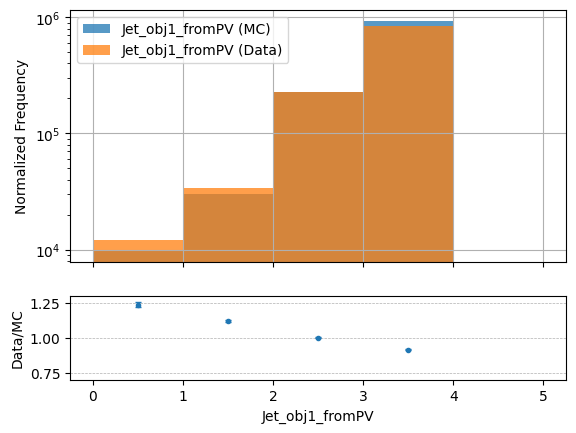

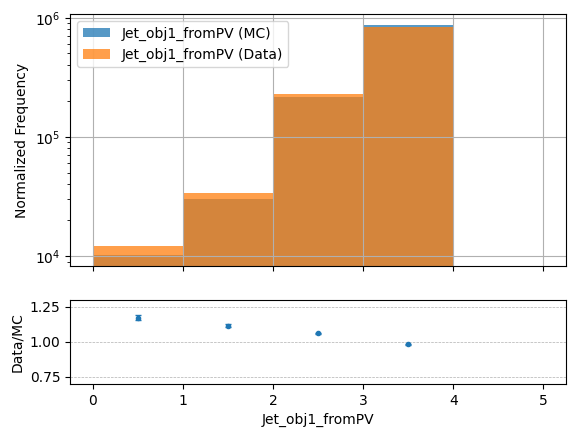

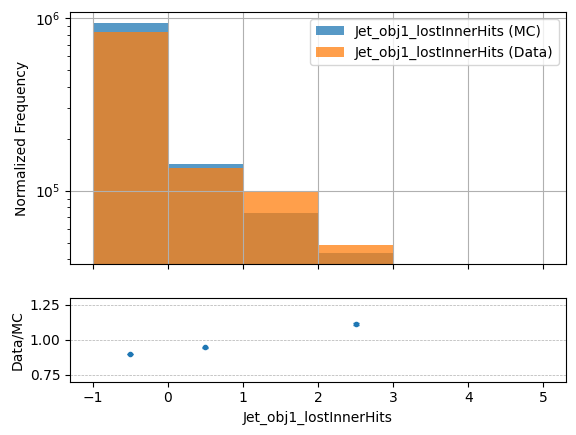

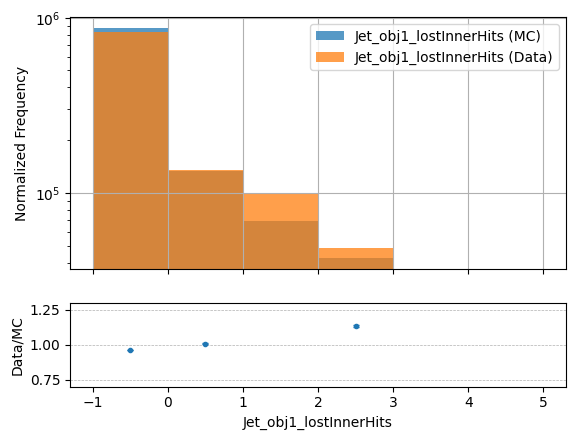

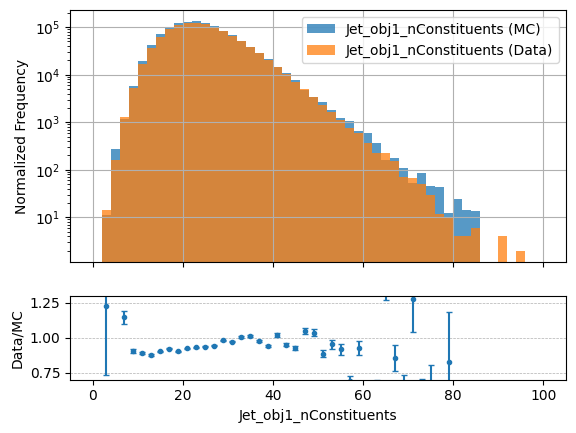

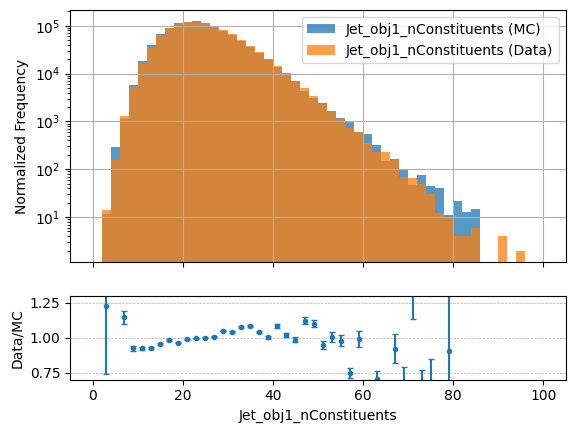

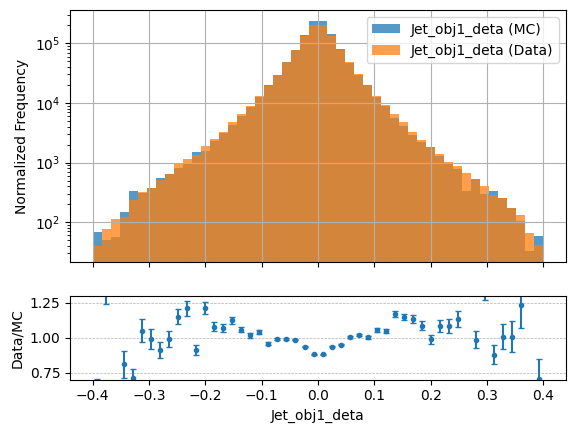

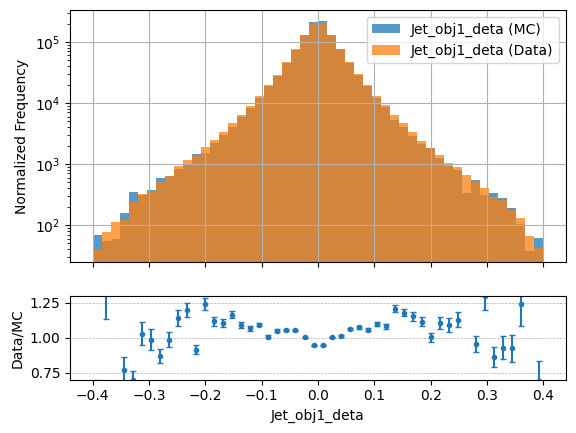

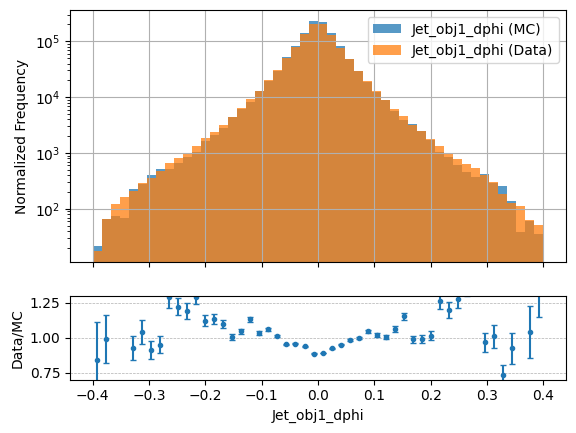

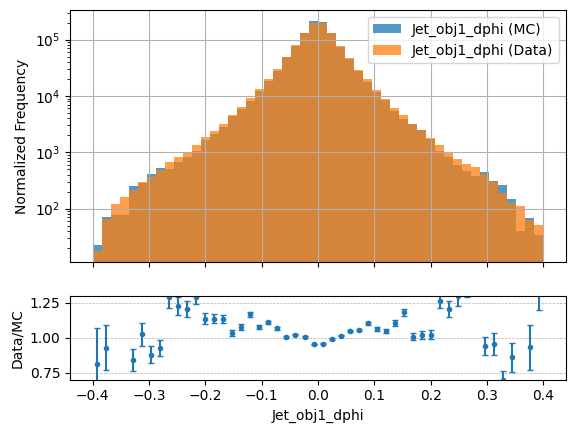

In [77]:
vars_list = {
                "pt"  : [50, [0, 500]],
                "eta" : [50, [-2.3, 2.3]],
                "phi" : [50, [-3.14, 3.14]], 
                "mass": [50, [0, 100]],
                "dxy" : [50, [0, 10]], 
                "dz"  : [50, [0, 10]], 
                "maxdz" : [30, [0, 30]], 
                "dxysig" : [30, [0, 90]], 
                "maxdxy" : [50, [0, 10]], 
                "maxdxysig" :[30, [0, 90]], 
                "dxy_weight": [50, [0, 10]], 
                "dxysig_weight" : [30, [0, 90]], 
#                 "disTauTag_score1" , 
                "dz_err" : [30, [0, 10]], 
                "dxy_err" : [30, [0, 10]], 
                "vz" : [30, [0, 10]], 
                "vxy" : [30, [0, 10]], 
                "fromPV" : [5, [0, 5]], 
                "lostInnerHits" : [6, [-1, 5]], 
                "nConstituents" : [50, [0, 100]], 
                "deta" : [50, [-0.4, 0.4]],
                "dphi" : [50, [-0.4, 0.4]] 
                #, "partonFlavour", "hadronFlavour"
            }


for param in vars_list.keys():
    compare_histograms(tree_dy, tree_data, f"Jet_obj1_{param}", bins=vars_list[param][0], range=tuple(vars_list[param][1]))
    compare_histograms(tree_dy, tree_data, f"Jet_obj1_{param}", ext_weight = weights_score, bins=vars_list[param][0], range=tuple(vars_list[param][1]))

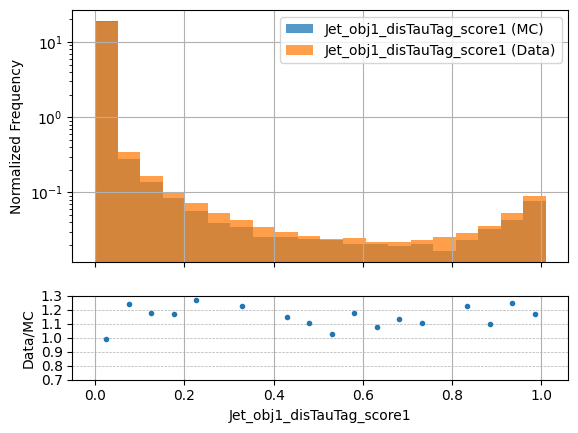

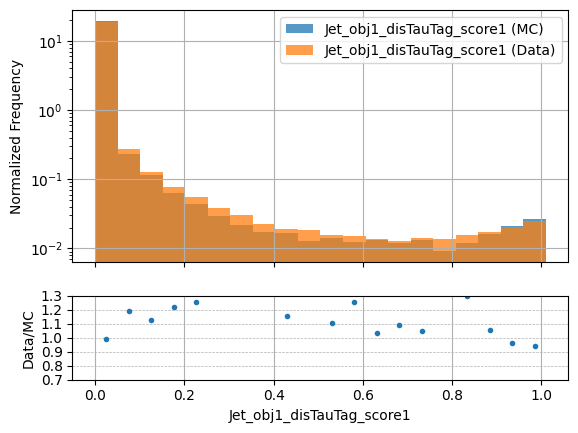

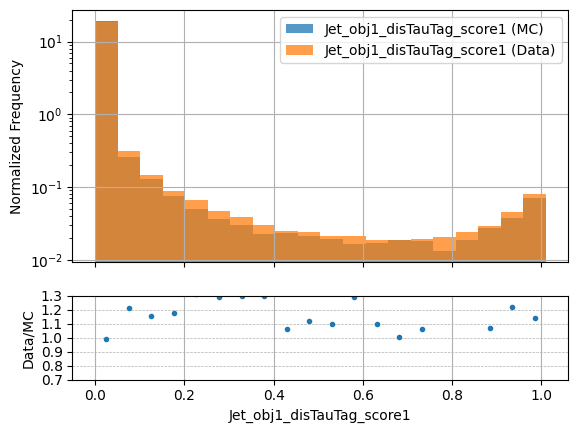

In [86]:
compare_histograms(tree_dy, tree_data, 'Jet_obj1_disTauTag_score1', bins=20, range=(0.0, 1.01), cut="")
compare_histograms(tree_dy, tree_data, 'Jet_obj1_disTauTag_score1', bins=20, range=(0.0, 1.01), cut="(Jet_obj1_fromPV>=3)&(Jet_obj1_lostInnerHits<=0)")
compare_histograms(tree_dy, tree_data, 'Jet_obj1_disTauTag_score1', bins=20, range=(0.0, 1.01), cut="(Jet_obj1_lostInnerHits<=0)")